# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization

 * Deep Learning for Computer Vision – Winter Term 2023/24
 * Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
 * Tutors: Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal
 * Due date: **Tuesday, Nov 7, before 10:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`

## Introduction

In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
- [PyTorch tutorial](https://pytorch.org/tutorials/)
- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [7]:
import os
import time
import pathlib
import fastprogress

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### GPU and CUDA checks

Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [9]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the bottom-right corner menu `<` -> `Notebook options` -> `Accelerator` -> Select `GPU P100` as Hardware accelerator.

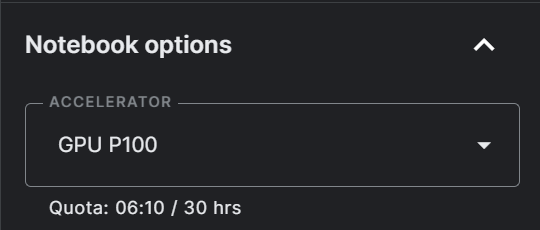

Now check the availability again (you would have to re-run the imports)

In [10]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

In [10]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [11]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
4 CPUs available


## Deep Learning with PyTorch

The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the **learning rate which influences how big the changes of the parameters should be after calculating the loss.**

The model fitting is split into training and evaluation. In the training process the model does a **forward pass** which means the data is presented to the model and the model outputs a prediction. The **loss** compares the prediction with the ground truth. In the **backward pass** the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the **evaluation process** the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to **avoid overfitting**. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.

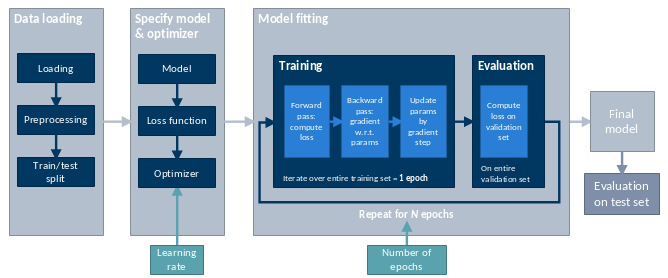

## Data Loading

## CIFAR dataset

This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.

**Download** the CIFAR dataset using torchvision dataset classes.

In [12]:
# DO NOT CHANGE
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

Files already downloaded and verified


Let's check the first ten samples to see what they look like

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


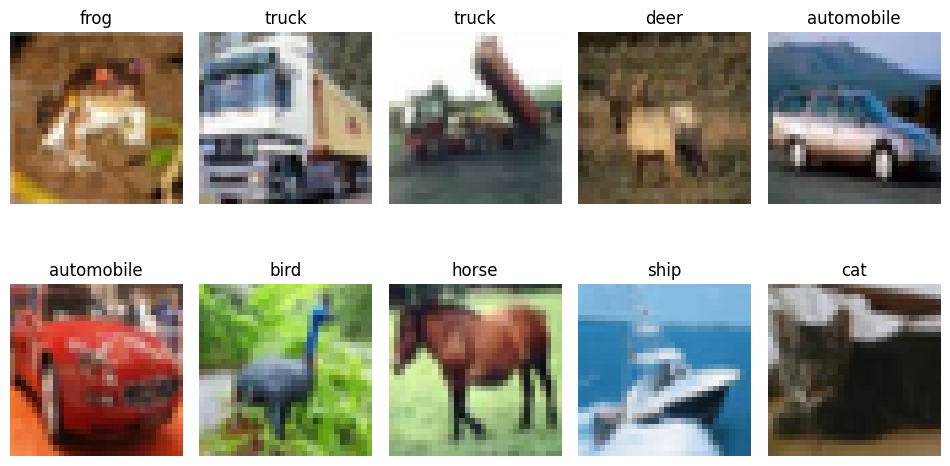

In [28]:
# TODO: display the label and the image

# Define a function to display the CIFAR-10 images and labels
print(cifar.classes)

def show_cifar_images(images, labels, ncols = 5, nrows = 2):
    fig, axes = plt.subplots(nrows, ncols, figsize = (12, 6))
    for i, ax in enumerate(axes.flatten()):
        # Get the image and label
        image = images[i]
        label = cifar.classes[labels[i]]

        # Display the image
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1)
    plt.show()

# Load the first 10 samples
num_samples = 10
cifar_subset = [cifar[i] for i in range(num_samples)]
img_samples, labels_samples = zip(*cifar_subset)

# Show the images and labels
show_cifar_images(img_samples, labels_samples)

Look at the types of X and y.

In [29]:
# TODO: display types
X_sample, y_sample = cifar[0] # first obs

print(X_sample)
print(f"X_sample type: {type(X_sample)}")
    # from the image module

print(y_sample)
print(f"y_sample type: {type(y_sample)}")

<PIL.Image.Image image mode=RGB size=32x32 at 0x7AAF732B3460>
X_sample type: <class 'PIL.Image.Image'>
6
y_sample type: <class 'int'>


How many data points are there in the dataset?

In [30]:
# TODO: print out the length of the dataset
dataset_length = len(cifar)
print(f"Number of observations: N = {dataset_length}")

Number of observations: N = 50000


## Loading data

### Preprocessing the Data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to transform _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ **to a torch tensor**.


#### Normalization

Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance.

See https://pytorch.org/vision/stable/transforms.html for more information.

We can combine multiple transformations via _transforms.Compose_.

Advantages:
- faster convergence
- reduce sensitivity to scale: stability!
- generalization/less overfitting: better performance on unseen pictures

In [24]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus) # batch = N
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3)) 
    # calculates the color channel mean mean over all images(batches, width and heigt)
    # each image is normalized in the same way per color channel
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std

#### Training, Validation and Test Sets

For the correct fitting of a neural network, we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

Note that you should not use the test set in any part of your training and model selection procedure. It should only be used for showing the final results.

We first need to **load** the datasets (above we did that already to calculate the normalization values. Then, we load them and **apply the normalization transform**)

We also need to **split** the train dataset into two sets, one for training and one for validation. While the training set needs to be quite large, the validation set can be relatively small. Take 20% of the dataset as validation set. Assign samples **_randomly_** to the training and validation set, using a fixed seed to ensure reproducibility.

In [23]:
# do not change
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    # gives 50k * 0.2
    num_train_samples = trainset.data.shape[0] - num_val_samples # rest
    trainset, valset = torch.utils.data.random_split(trainset, 
                                                    (num_train_samples, num_val_samples), 
                                                    generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset

To load the data for model training, we need to define **dataloaders**. A dataloader represents a Python iterable over a dataset and draws mini batches with random samples. Obseve below that we have a default number for batch size, and we shuffle the samples in batches.

In [22]:
# do not change
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=batch_size,
                                             shuffle=True, 
                                             num_workers=num_cpus)
    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [25]:
# Load the training and testing datasets
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir, num_cpus=4)
    # the testset has 10k obs by default

# Split the training data into a training set and a validation set for model evaluation (80/20).
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
    # split 50k into 80/20 train/val

# Initialize data loaders for training, validation, and testing.
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=4)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all the class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [42]:
# Print all class names:
print("Class names:")
cifar.classes


Class names:


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [44]:
print(f"Mean per color channel: {dataset_mean}")
print(f"Std. dev. per color channel: {dataset_std}")

# Reshape
#dataset_mean.view(3, 1, 1)

Mean per color channel: tensor([0.4914, 0.4822, 0.4465])
Std. dev. per color channel: tensor([0.2470, 0.2435, 0.2616])


In [110]:
def imshow(img, mean=None, std=None, ax=None):
    """"Undo normalization using mean and standard deviation and show image on the specified axis.

    Args:
        img (torch.Tensor): Image to show
        ax (matplotlib axis or None): Axis to display the image. If None, a new axis will be created.
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    
    #img = torchvision.transforms.ToPILImage(img)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    
    if mean is not None and std is not None:
        # Undo normalization (Reshape mean and st. dev.)
        img_orig = (img * std.view(3, 1, 1)) + mean.view(3, 1, 1) 
    else:    
        img_orig = img
    
    # reshaping image
    # Change the tensor to (32, 32, 3) for plotting (height, widht, channel)
    img_orig = img_orig.permute(1, 2, 0) # this is as in the PIL_Image format
            
    # Plot image on the specified axis
    ax.imshow(img_orig)
    ax.axis('off')

In [45]:
#print(trainset[0][0])

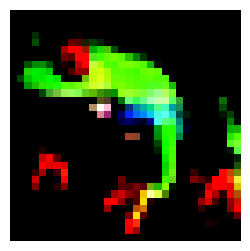

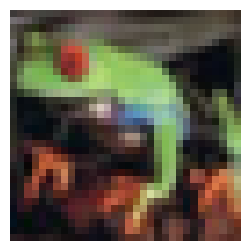

In [111]:
# Normalized
imshow(trainset[0][0])

# Unnormalized
imshow(trainset[0][0],dataset_mean, dataset_std)

Sample indices [7296, 1639, 18024, 16049, 14628, 9144, 6717, 35741, 5697, 38698, 27651, 2082, 1952, 6140, 14328, 15247]


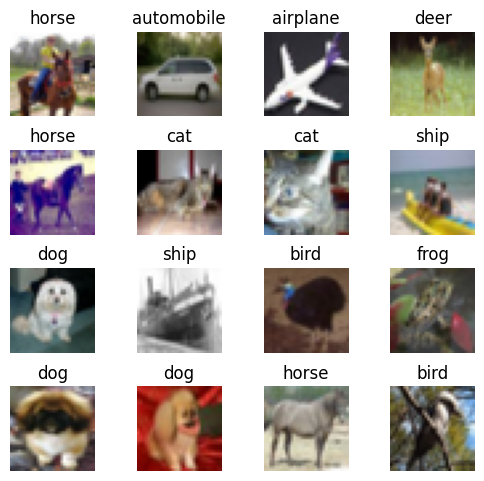

In [112]:
# Create actual plot and print the class names

import random
num_samples = 16
random.seed(42)
indices = random.sample(range(len(trainset)), num_samples)

print(f'Sample indices {indices}')

trainset_sample = [trainset[i] for i in indices]

#trainset_sample[0] # this is the first obs in sample

img_sample = [observation[0] for observation in trainset_sample]
labels_sample = [observation[1] for observation in trainset_sample]

# Show the images and labels
def show_trainsample_images(images, labels, mean, std, ncols = 4, nrows = 4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        # Get the image and label
        image = images[i]
        label = cifar.classes[labels[i]]

        # Display the image
        imshow(image, mean, std, ax)
        ax.set_title(label)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace = 0.1)
    plt.show()

# Show the images and labels
show_trainsample_images(img_sample, labels_sample, dataset_mean, dataset_std)

Now that you know what CIFAR10 looks like, you can guess what the task for this dataset is: classification in natural images

## Training, evaluation and plotting functions

Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [4]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            # My implementation:
            if early_stopper.early_stop(accuracy = epoch_val_acc, model = model):
                print(f"Early stopping at epoch {epoch + 1}!")
                break
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        # My implementation:
        x_extra, y_extra = extra_pt
        plt.plot(x_extra, y_extra, c='black', marker='X', markersize = 10, label=extra_pt_label)
        legend.append(extra_pt_label)
        legend = ['Train results', 'Validation results', 'Highest Validation-Accuracy']
               
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    
    return plot

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [8]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        # Define input and output dimensions
        input_dim = img_width * img_width * num_in_channels
        output_dim = num_classes
        
        super(MLP, self).__init__() #inherit from nn.Module parent class
        
        # Create an empty Module list to store the layers (we could also just use nn.Sequential)
        self.layers = nn.ModuleList()
        
        # Input Layer
        self.layers.append(nn.Linear(input_dim, num_hidden_units))
        # (ReLu) Activation Function after Input Layer
        if act_fn is not None:
            self.layers.append(act_fn())
        else:
            self.layers.append(nn.ReLU())
            
        # Add hidden layers + activation function after each hidden layer
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            if act_fn is not None:
                self.layers.append(act_fn())
            else:
                self.layers.append(nn.ReLU())
                
        # Final layer that creates output
        self.layers.append(nn.Linear(num_hidden_units, output_dim))
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        # Flatten input
        x = x.view(x.size(0), -1)  
        
        # Forward pass through layers
        for layer in self.layers:
            x = layer(x)
        return x


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.

#### TODO:
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

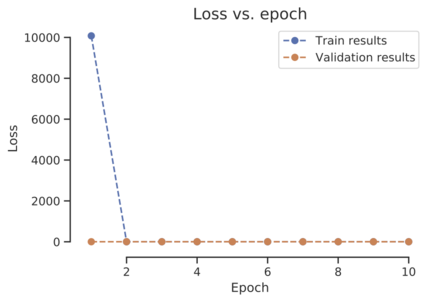

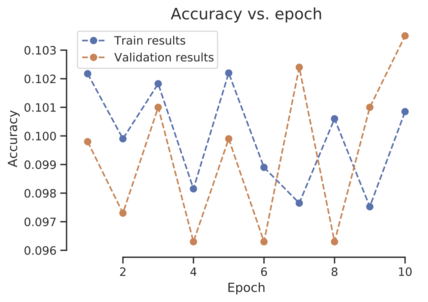

Model stars already with high loss (bad initialization: model too complex, wrong parameters, lr too high, initial weights are completely wrong, training set not normalized - scale differs from validation?) 
Model learns a lot from 1 to 2 epoch and then the loss stays relatively unchanged. High lerning rate at beginning an then lower one?

Learning rate could be too high (or close to 1)
This can lead to very large updates to the model's parameters, potentially causing instability and divergence in the training process. The model may overshoot optimal parameter values, resulting in poor convergence and possibly even divergence, where the loss increases indefinitely. This is what can be seen it the second image.

**This is an example of a model that does train:** *(Why?)*

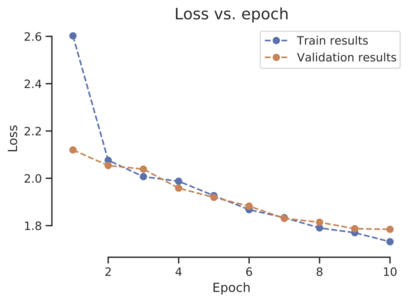

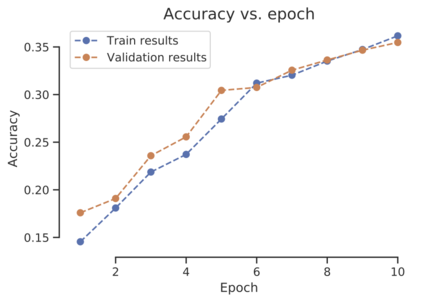

The loss/accuracy constantly decreases/increases. Training approx. equals validation. No overfitting. Loss is very low in general => Good initialization

In [15]:
####################
## YOUR CODE HERE ##
####################

# Set up model with images of input_dim: 32x32x3 and output_dim = 10, ReLU activation function and 1 hidden layers
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)

In [19]:
# Loss function, epochs, and learning rates
loss_function = nn.CrossEntropyLoss()
num_epochs = 10

learning_rates = [1.0, 0.1, 0.01, 0.001]

In [122]:
# Start training

# Create lists to store training results for each learning rate
training_results = []

# Loop over different learning rates
for lr in learning_rates:
    print(f'Using learning rate: {lr}')
    # Initialize the optimizer with the current learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model and store the training curves
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader)
    
    training_results.append((lr, train_losses, val_losses, train_accs, val_accs))
    
    print("")

Using learning rate: 1.0


Finished training after 64 seconds.

Using learning rate: 0.1


Finished training after 59 seconds.

Using learning rate: 0.01


Finished training after 59 seconds.

Using learning rate: 0.001


Finished training after 62 seconds.



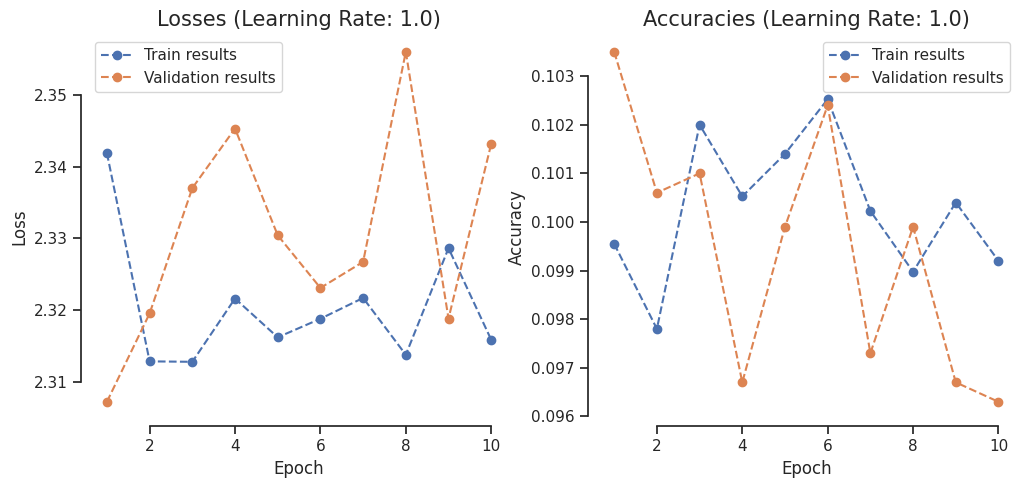

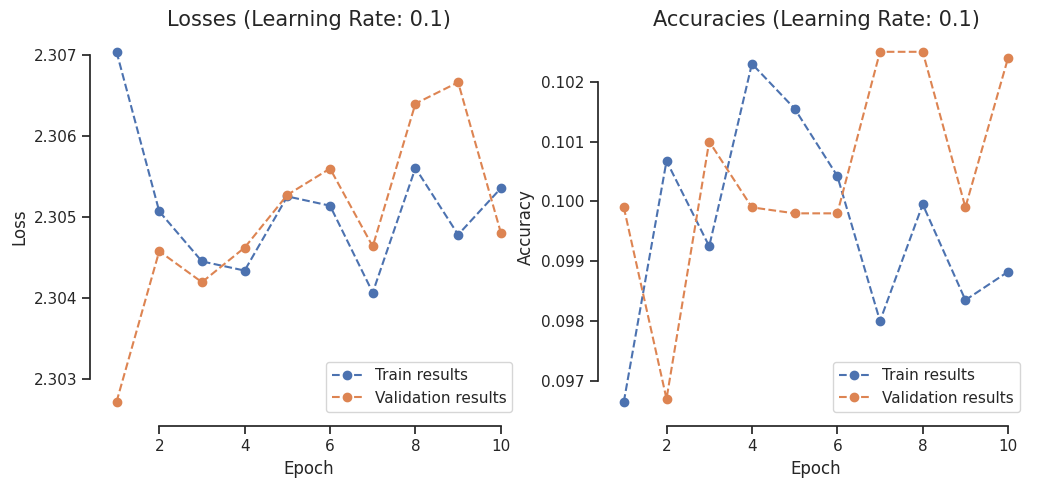

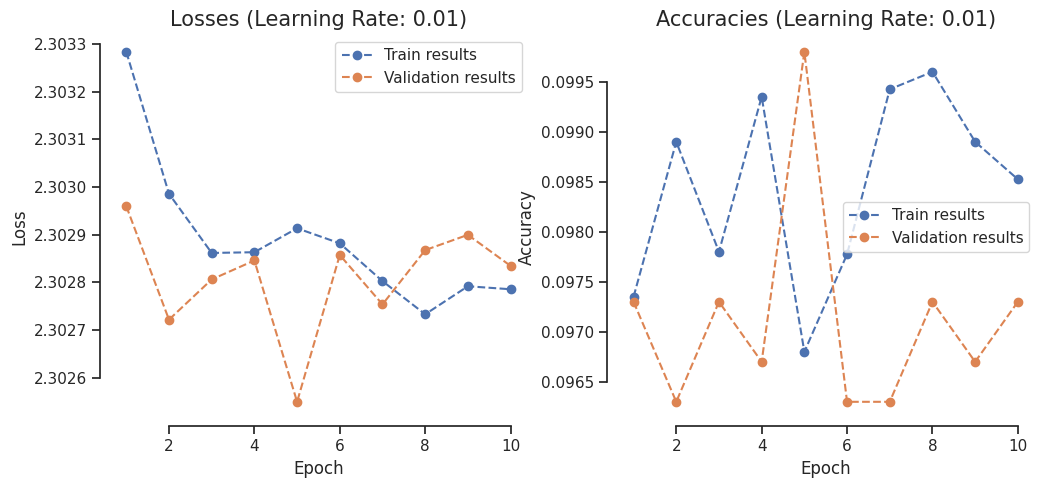

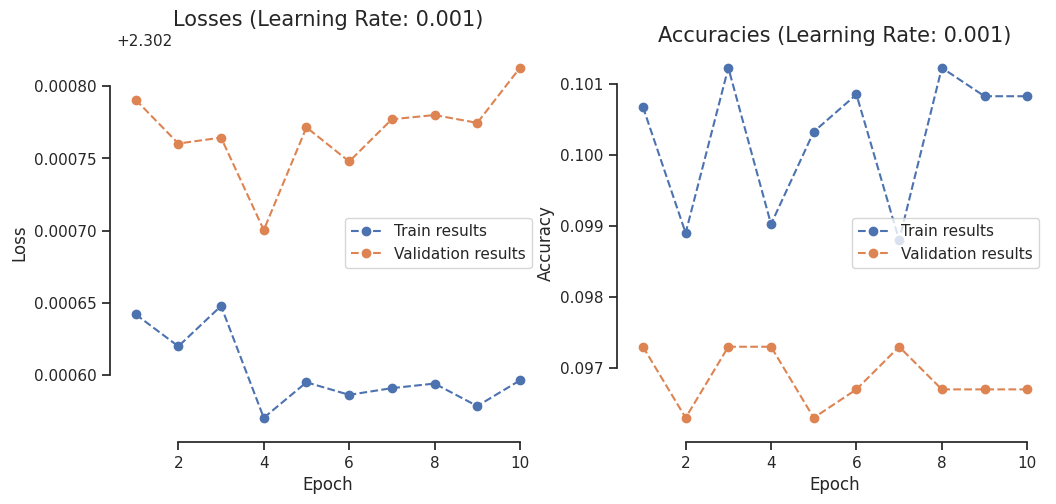

In [149]:
# Plot the training curves for each learning rate
for i, lr in enumerate(learning_rates):
    fig = plt.figure(figsize=(12, 5))

    # Plot Loss/Epoch
    plt.subplot(1, 2, 1)
    plot(f"Losses (Learning Rate: {lr})", "Loss", training_results[i][1], training_results[i][2])

    # Plot Accuracy/Epoch
    plt.subplot(1, 2, 2)
    plot(f"Accuracies (Learning Rate: {lr})", "Accuracy", training_results[i][3], training_results[i][4])

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [141]:
####################
## YOUR CODE HERE ##
####################

# Define model and parameters
# I take the model with lr = 0.01 since in my opinion it learns best
model100 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)
num_epochs = 100
lr = 0.01

# Initialize the optimizer with the chosen learning rate
optimizer = optim.Adam(model100.parameters(), lr=lr)
    
# Start training
train_losses100, val_losses100, train_accs100, val_accs100, _ = run_training(model100, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader)

Finished training after 610 seconds.


<function __main__.plot(title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)>

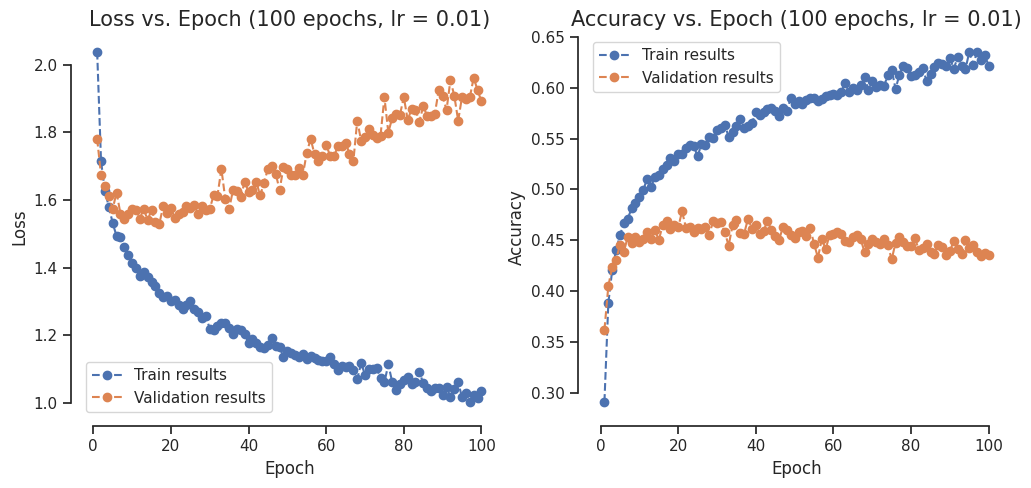

In [150]:
fig = plt.figure(figsize=(12, 5))

# Plot Loss/Epoch
plt.subplot(1, 2, 1)
plot('Loss vs. Epoch (100 epochs, lr = 0.01)','Loss', train_losses100, val_losses100)

# Plot Accuracy/Epoch
plt.subplot(1, 2, 2)
plot('Accuracy vs. Epoch (100 epochs, lr = 0.01)','Accuracy', train_accs100, val_accs100)

In [182]:
# Best loss for validation set (minimum)
min_loss_val100 = min(val_losses100)
min_loss_val100_epoch = val_losses100.index(min_loss_val100)+1
print(f"Best loss value for validation set (min): {min_loss_val} in epoch {min_loss_val_epoch}")
print("")

# Best accuracy for validation set (maximum)
max_acc_val100 = max(val_accs100)
max_acc_val100_epoch = val_accs100.index(max_acc_val100)+1
print(f"Best accuracy value for validation set (max): {max_acc_val100} in epoch {max_acc_val100_epoch}")

Best loss value for validation set (min): 1.5290185928344726 in epoch 17

Best accuracy value for validation set (max): 0.4785 in epoch 21


Let's have a look at those training curves! Here are some questions for you.

#### TODO:
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. Yes, it does. The model is learning more and more from one epoch to another. Gradients are adjusted until they converge and reach the optimum. There is no overshooting but gradual approximation. Model is training good on the training set. The minimum is not yet reached => no convergence => it seems like we can continue training the model indefinitely and the values will still improve. There is not much of a fluctuation (no overshooting but instead the curve does reduce very stable (learning rate is not too high).

2. It does up to epoch ~20 (these weights work best on validation set!) which is good but at that point the model performace reverses. The acc. for the validation set gets lower again and the loss higher. This is a sign for overfitting to the training set at that point. The curves for the training and validation sets do not converge. Instead, the model gets better and better on the training set and learns too much. However, the training is very stable and there is not much of fluctuation (learning rate not too high).

3. Training: Yes; Validation: Up to epoch ~20 yes, after that it decreases. Explanation can be seen above but this time the other way round.

4. Best loss: 17; best acc: 21; no they are not but compared to the whole range of epochs they are very close to each other.

5. mhh.. These metrics capture different aspects of model performance. Could be randomness? The values between 17 and 21 do not differ that much.

6. I would choose the epoch with the highest accuracy on the validation set. I.e., epoch 21. After that we start overfitting. This model generalizes best. I would decide for the accuracy instead of the loss since loss is rather used for internal optimization and accuracy is a measure we are interested at as a user. (However, you could also argument for using the model after epoch 17...?). Should be one of the models in this range.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO:
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [164]:
####################
## YOUR CODE HERE ##
####################
# feel free to add more cells here

#print(model100.state_dict())

print("Content of model's checkpoint:")
print("")
print("Model:")
print(model100)
print("")
print("state_dict: Weights and Biases")
for param_tensor in model100.state_dict():
    print(param_tensor, "\t", model100.state_dict()[param_tensor].size())

print("")
print("Optimizer:")
print(optimizer)

checkpoint = {'model': model100,
              'state_dict': model100.state_dict(),
              'optimizer' : optimizer.state_dict()}
#print(checkpoint)
torch.save(checkpoint, 'checkpoint.pth')
# pth extension is for PyTorch state dictionaries


Content of model's checkpoint:

Model:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=10, bias=True)
  )
)

state_dict: Weights and Biases
layers.0.weight 	 torch.Size([30, 3072])
layers.0.bias 	 torch.Size([30])
layers.2.weight 	 torch.Size([30, 30])
layers.2.bias 	 torch.Size([30])
layers.4.weight 	 torch.Size([10, 30])
layers.4.bias 	 torch.Size([10])

Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [166]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False # freezing the part of the model as no changes happen to its parameters
    
    model.eval()
    
    return model

#model_restored = load_checkpoint('checkpoint.pth')
#print(model_restored)

In [167]:
# Check if it works to restore model
model2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)
validation_acc_model2 = validate(valloader,model2, loss_function, device = device, master_bar = None)[1]

In [169]:
print("Untrained Model2 Validation Set Accuracy:")
print(validation_acc_model2)

Untrained Model2 Validation Set Accuracy:
0.0849


In [170]:
# Restore model / overwrite weights
model2 = load_checkpoint('checkpoint.pth')
validation_acc_model2_restored = validate(valloader,model2, loss_function, device = device, master_bar = None)[1]
validation_acc_model100 = validate(valloader,model100, loss_function, device = device, master_bar = None)[1]

print("Restored Model2 Validation Set Accuracy:")
print(validation_acc_model2_restored)
print("")
print("Model100 Validation Set Accuracy:")
print(validation_acc_model100)


Restored Model2 Validation Set Accuracy:
0.4355

Model100 Validation Set Accuracy:
0.4355


Much higher now => Model is trained now. Furthermore, they are the same.

## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [ ]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pth', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        # Inputs:
        self.verbose = verbose
        self.patience = patience
        self.path = path
        
        self.counter = 0
        self.best_accuracy = None
        self.update = False

    #@property
    def early_stop(self, accuracy, model):
        """True if early stopping criterion is reached.
    
        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        if self.best_accuracy is None or accuracy > self.best_accuracy: # first epoch or worse
            self.best_accuracy = accuracy
            self.counter = 0
            if self.verbose:
                print(f'Saving checkpoint with accuracy: {accuracy}')
            self.save_checkpoint(model)
        else:
            self.counter += 1 # Compare with patience
            if self.verbose:
                print(f'Patience counter: {self.counter}')
            if self.counter >= self.patience: # when patience is reached
                if self.verbose:
                    print(f'Early stopping triggered')
                return True
        return False
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

    #def load_checkpoint(self, model):
     #   model.load_state_dict(torch.load(self.path))
      #  if self.verbose:
       #     print(f'Checkpoint loaded. Best accuracy: {self.best_accuracy}')

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [219]:
####################
## YOUR CODE HERE ##
####################
model_stop = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)

stopper = EarlyStopper(patience = 1)

num_epochs = 100

# Initialize the optimizer with the current learning rate
optimizer = optim.Adam(model_stop.parameters(), lr=0.01)
    
# Train the model and store the training curves
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_stop, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper = stopper)

Early stopping at epoch 7!
Finished training after 41 seconds.


#### TODO:
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

The highest accuracy achieved in this ES-model is 0.4561.
When training with 100 epochs we reached an maximum accuracy of 0.4785

Thus, we are close but the maximum is not yet reached. Patience of 1 is a bad choice due to random fluctuations.


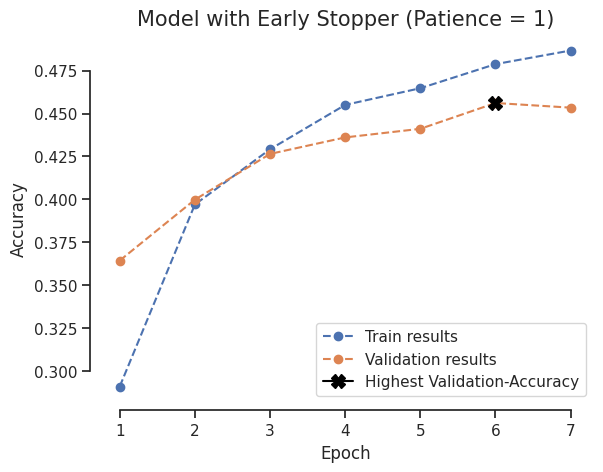

In [220]:
# Compare:
max_acc_val = max(val_accs)
max_acc_val_epoch = val_accs.index(max_acc_val)+1
plot('Model with Early Stopper (Patience = 1)','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
print(f'The highest accuracy achieved in this ES-model is {max_acc_val}.')
print(f'When training with 100 epochs we reached an maximum accuracy of {max_acc_val100}')
print("\nThus, we are close but the maximum is not yet reached. Patience of 1 is a bad choice due to random fluctuations.")


Initializing early stopper with patience of 2


Early stopping at epoch 10!
Finished training after 57 seconds.
The highest accuracy achieved in this ES-model is 0.4621.

Initializing early stopper with patience of 4


Early stopping at epoch 13!
Finished training after 74 seconds.
The highest accuracy achieved in this ES-model is 0.4624.

Initializing early stopper with patience of 6


Early stopping at epoch 23!
Finished training after 132 seconds.
The highest accuracy achieved in this ES-model is 0.4762.



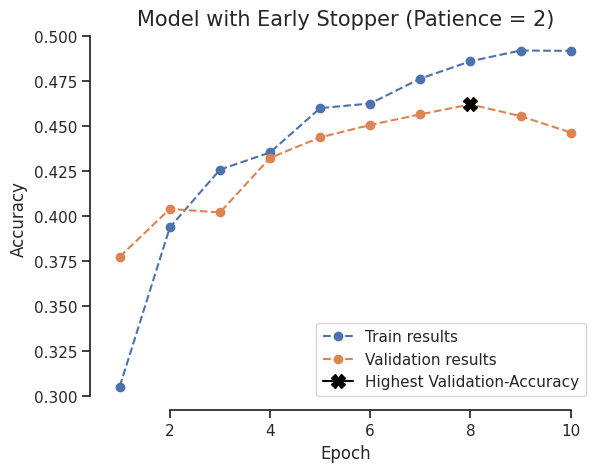

<Figure size 640x480 with 0 Axes>

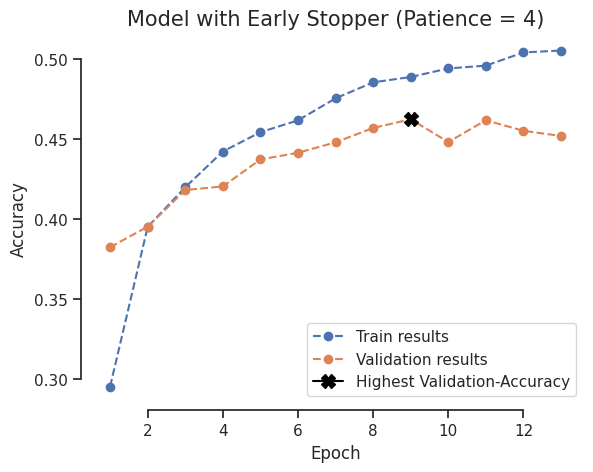

<Figure size 640x480 with 0 Axes>

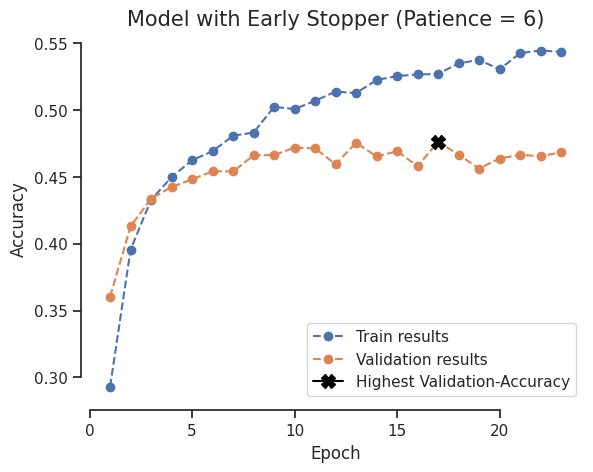

<Figure size 640x480 with 0 Axes>

In [221]:
# Compare different values for patience
patience_values = [2, 4, 6]
num_epochs = 100

for pat in patience_values:
    print(f"Initializing early stopper with patience of {pat}")
    model_patience = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)
    optimizer = optim.Adam(model_patience.parameters(), lr=0.01)

    stopper = EarlyStopper(patience=pat)
    
    # Train the model and store the training curves
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model_patience, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)
    
    max_acc_val = max(val_accs)
    max_acc_val_epoch = val_accs.index(max_acc_val)+1
    fig = plt.figure()
    plot(f'Model with Early Stopper (Patience = {pat})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
    fig = plt.figure()
    print(f'The highest accuracy achieved in this ES-model is {max_acc_val}.')
    print("")
    
    

I ended up at a model which is close to the best accuracy achieved in model100 when I use patience = 6.
Using patience = 6 yields the best acc on the validation set (0.4762) which is is close to the 0.4785 achieved in model100 but without the necessity of trainig 100 epochs. => use patience = 6 in the following.

In [230]:
patience = 6

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

Early stopping at epoch 41!
Finished training after 235 seconds.
The highest accuracy achieved in this model is 0.4869.


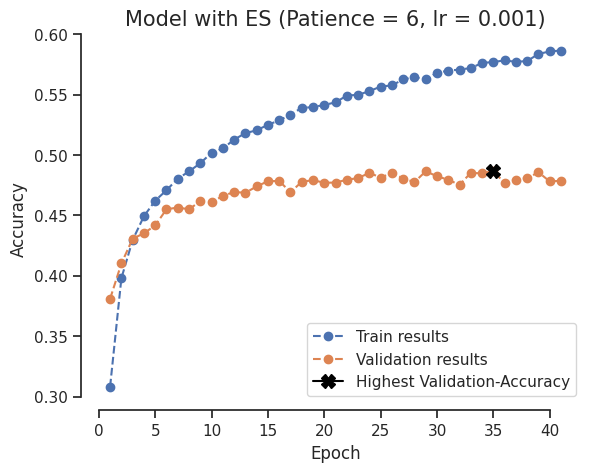

In [222]:
lr = 1e-3 # 0.001

model_lr1 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)

stopper = EarlyStopper(patience = patience)

num_epochs = 100

optimizer = optim.Adam(model_lr1.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_lr1, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)

max_acc_val = max(val_accs)
max_acc_val_epoch = val_accs.index(max_acc_val)+1

fig = plt.figure()
plot(f'Model with ES (Patience = {patience}, lr = {lr})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
print(f'The highest accuracy achieved in this model is {max_acc_val}.')

**new record**!

Early stopping at epoch 71!
Finished training after 408 seconds.
The highest accuracy achieved in this model is 0.4715.


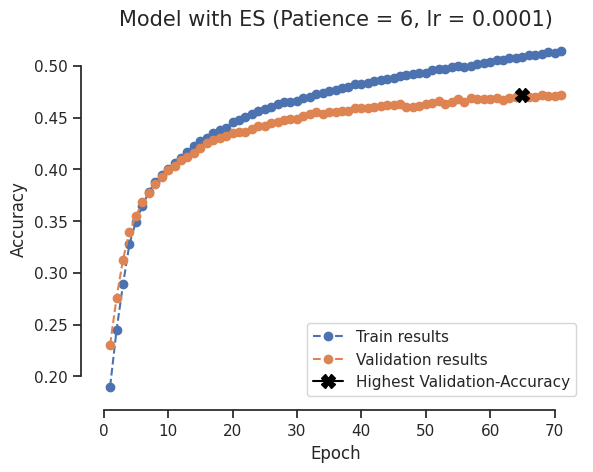

In [229]:
lr = 1e-4 # 0.0001

model_lr2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1).to(device)

stopper = EarlyStopper(patience = patience)

num_epochs = 100

optimizer = optim.Adam(model_lr2.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_lr2, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)

max_acc_val = max(val_accs)
max_acc_val_epoch = val_accs.index(max_acc_val)+1

fig = plt.figure()
plot(f'Model with ES (Patience = {patience}, lr = {lr})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
print(f'The highest accuracy achieved in this model is {max_acc_val}.')

Using lr = 0.001 results in a higher predictive accuracy on the validation set than when using lr = 0.01 (0.4869 vs. 0.4785). However, lr = 0.0001 yields lower accuracy.
Furthermore, the second model took much longer to finish. This speaks definetly in favor of using lr = 1e-3 since the model gets trained better and faster.

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

**Remember that the maximum accuracy I reached with lr = 0.001, patience = 2, hidden_units = 30, hidden_layers = 1, and ReLu() activation function was: 0.4869**

Initializing model with 10 hidden units.


Early stopping at epoch 24!
Finished training after 138 seconds.
The highest accuracy achieved in this model is 0.4196.

Initializing model with 20 hidden units.


Early stopping at epoch 28!
Finished training after 162 seconds.
The highest accuracy achieved in this model is 0.4641.

Initializing model with 30 hidden units.


Early stopping at epoch 28!
Finished training after 159 seconds.
The highest accuracy achieved in this model is 0.4811.

Initializing model with 40 hidden units.


Early stopping at epoch 21!
Finished training after 121 seconds.
The highest accuracy achieved in this model is 0.4918.

Initializing model with 50 hidden units.


Early stopping at epoch 29!
Finished training after 165 seconds.
The highest accuracy achieved in this model is 0.5031.



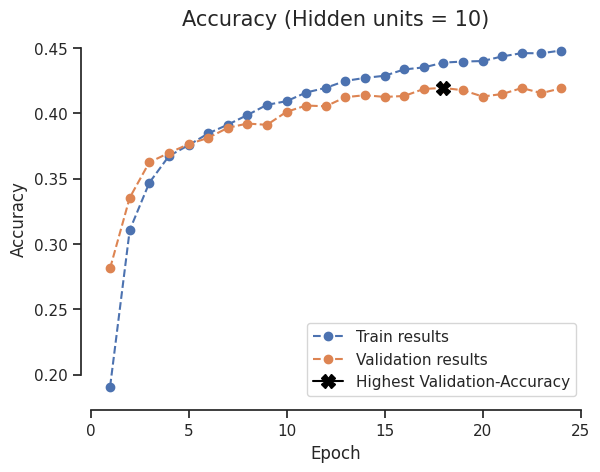

<Figure size 640x480 with 0 Axes>

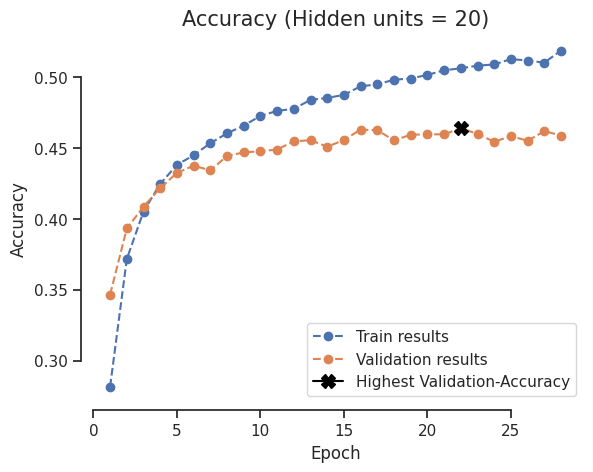

<Figure size 640x480 with 0 Axes>

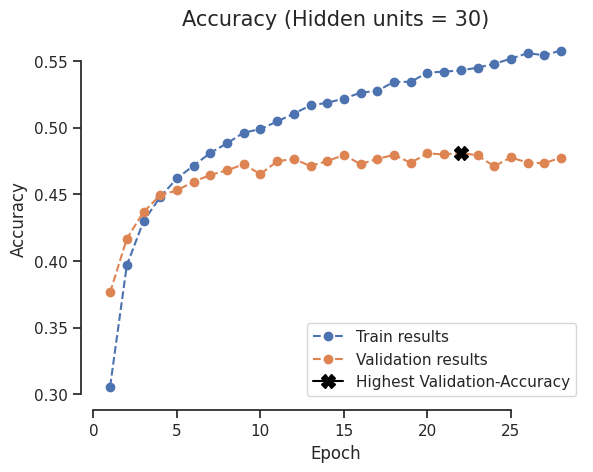

<Figure size 640x480 with 0 Axes>

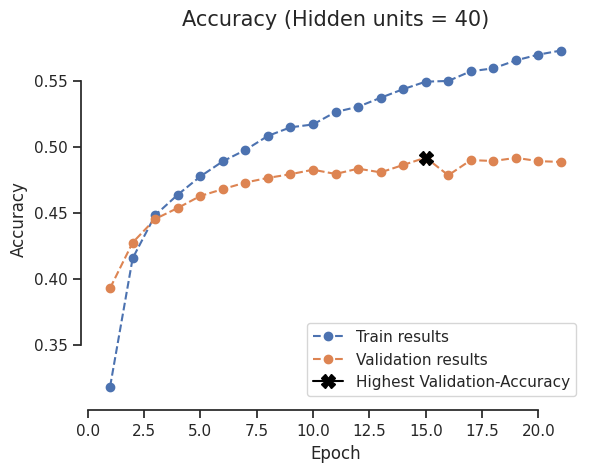

<Figure size 640x480 with 0 Axes>

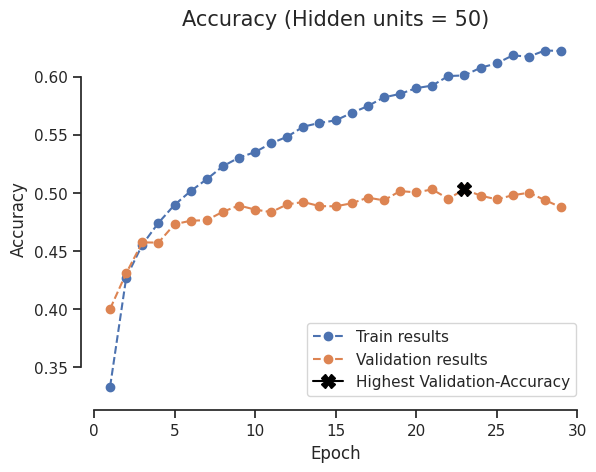

<Figure size 640x480 with 0 Axes>

In [225]:
# number of hidden units
hidden_units = [10, 20, 30, 40, 50]
lr = 1e-3
num_epochs = 100

for unit in hidden_units:
    print(f"Initializing model with {unit} hidden units.")
    model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = unit).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    stopper = EarlyStopper(patience=patience)
    
    # Train the model
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)
    
    max_acc_val = max(val_accs)
    max_acc_val_epoch = val_accs.index(max_acc_val)+1
    fig = plt.figure()
    plot(f'Accuracy (Hidden units = {unit})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
    fig = plt.figure()
    print(f'The highest accuracy achieved in this model is {max_acc_val}.')
    print("")

**new record**

50 Hidden Units give the highest accuracy (0.5031) => I take this value.

Initializing model with 1 hidden layers.


Early stopping at epoch 34!
Finished training after 195 seconds.
The highest accuracy achieved in this model is 0.4876.

Initializing model with 2 hidden layers.


Early stopping at epoch 33!
Finished training after 191 seconds.
The highest accuracy achieved in this model is 0.4866.

Initializing model with 3 hidden layers.


Early stopping at epoch 31!
Finished training after 186 seconds.
The highest accuracy achieved in this model is 0.4832.

Initializing model with 5 hidden layers.


Early stopping at epoch 62!
Finished training after 369 seconds.
The highest accuracy achieved in this model is 0.4818.

Initializing model with 8 hidden layers.


Early stopping at epoch 39!
Finished training after 243 seconds.
The highest accuracy achieved in this model is 0.4646.



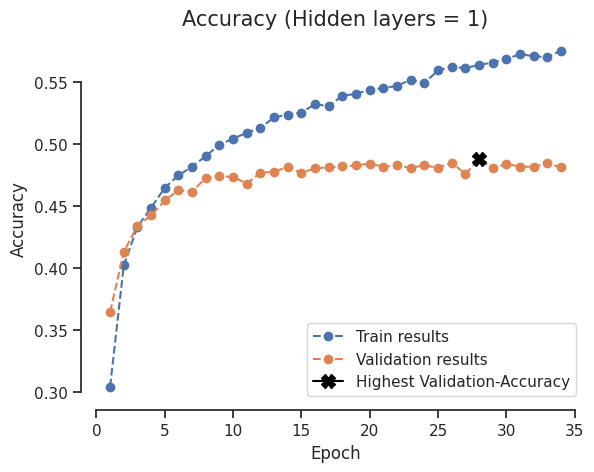

<Figure size 640x480 with 0 Axes>

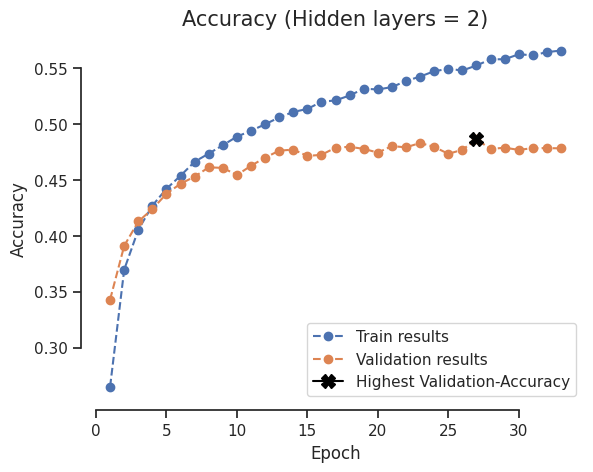

<Figure size 640x480 with 0 Axes>

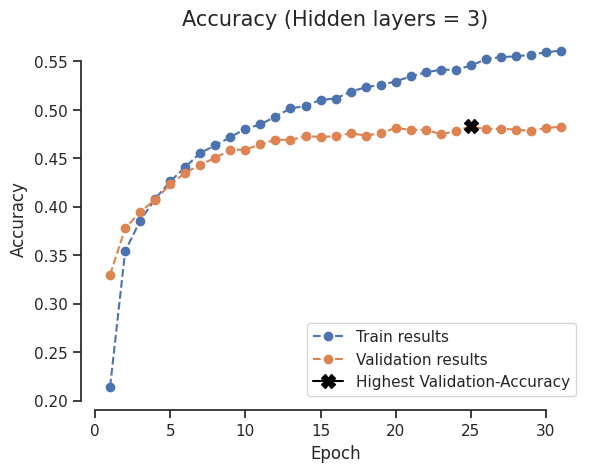

<Figure size 640x480 with 0 Axes>

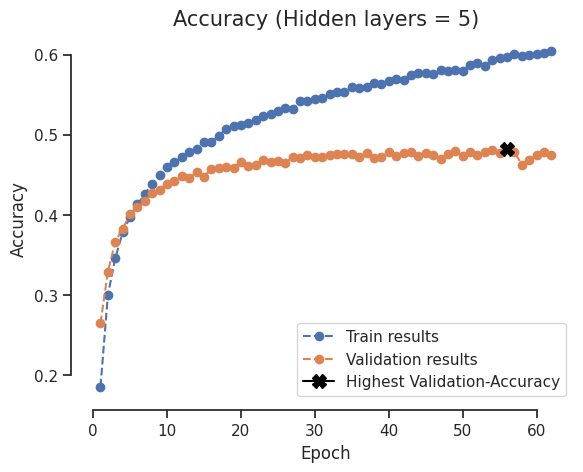

<Figure size 640x480 with 0 Axes>

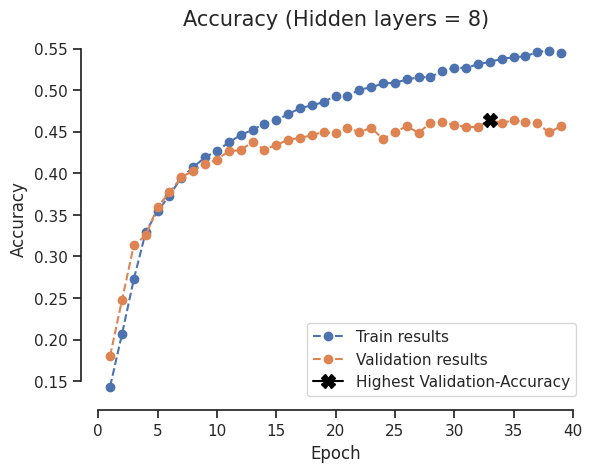

<Figure size 640x480 with 0 Axes>

In [232]:
# number of layers
hidden_layers = [1, 2, 3, 5, 8]

lr = 1e-3
num_epochs = 100

for layer in hidden_layers:
    print(f"Initializing model with {layer} hidden layers.")
    model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=layer, num_hidden_units = 30).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    stopper = EarlyStopper(patience=patience)
    
    # Train the model
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)
    
    max_acc_val = max(val_accs)
    max_acc_val_epoch = val_accs.index(max_acc_val)+1
    fig = plt.figure()
    plot(f'Accuracy (Hidden layers = {layer})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
    fig = plt.figure()
    print(f'The highest accuracy achieved in this model is {max_acc_val}.')
    print("")


Does not make much of a difference. Tendency is that Accuracy decreases. Furthermore, model takes way more time. => I stay with one hidden layer.

Initializing model with ELU activation function.


Early stopping at epoch 29!
Finished training after 180 seconds.
The highest accuracy achieved in this model is 0.4902.

Initializing model with ReLU activation function.


Early stopping at epoch 29!
Finished training after 176 seconds.
The highest accuracy achieved in this model is 0.4789.

Initializing model with Sigmoid activation function.


Early stopping at epoch 42!
Finished training after 253 seconds.
The highest accuracy achieved in this model is 0.4195.

Initializing model with Tanh activation function.


Early stopping at epoch 21!
Finished training after 127 seconds.
The highest accuracy achieved in this model is 0.4353.



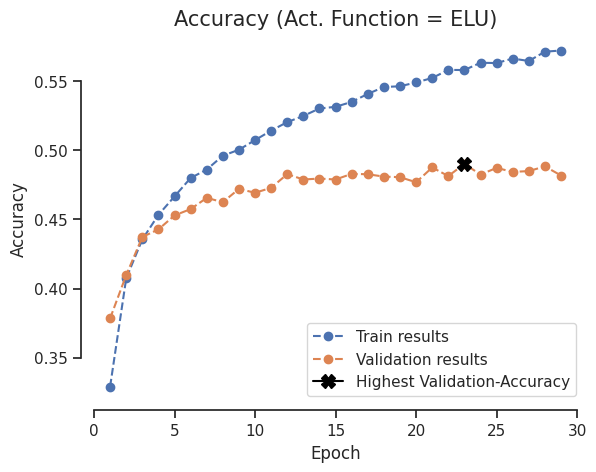

<Figure size 640x480 with 0 Axes>

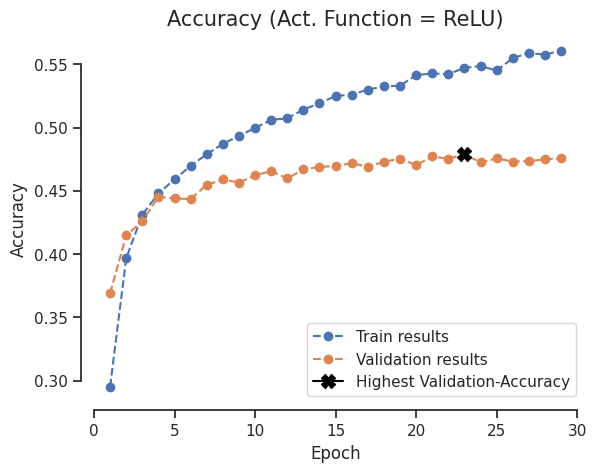

<Figure size 640x480 with 0 Axes>

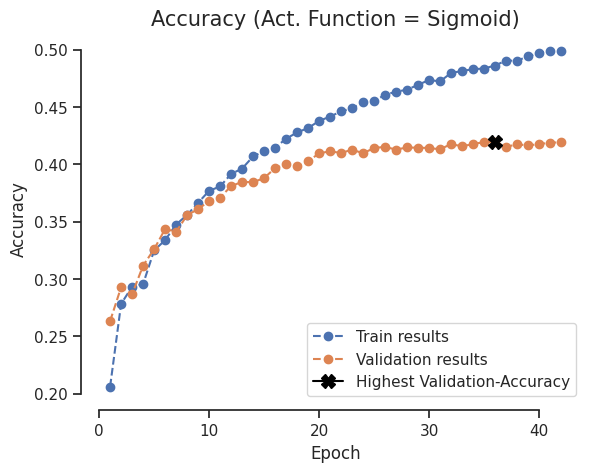

<Figure size 640x480 with 0 Axes>

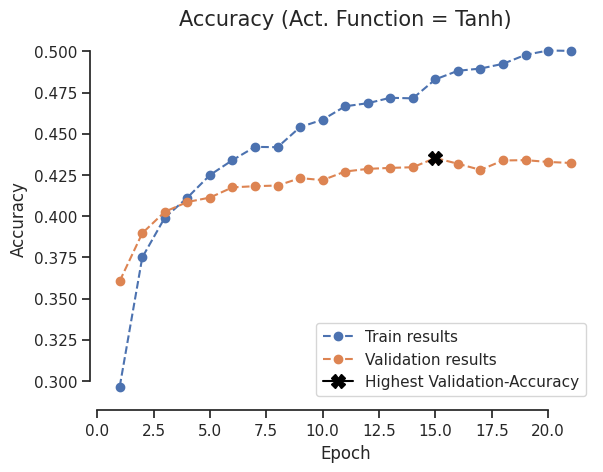

<Figure size 640x480 with 0 Axes>

In [235]:
# activation function
activation_functions = {"ELU": nn.ELU, "ReLU": nn.ReLU, "Sigmoid": nn.Sigmoid, "Tanh": nn.Tanh}

for name, af in activation_functions.items():
    print(f"Initializing model with {name} activation function.")
    model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units = 30, act_fn = af).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    stopper = EarlyStopper(patience=patience)
    
    # Train the model
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, 
                                                                   loss_function, device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)
    
    max_acc_val = max(val_accs)
    max_acc_val_epoch = val_accs.index(max_acc_val)+1
    fig = plt.figure()
    plot(f'Accuracy (Act. Function = {name})','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
    fig = plt.figure()
    print(f'The highest accuracy achieved in this model is {max_acc_val}.')
    print("")

The best value is achieved by ELU activation function (0.4902). => Take this one.

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- Validation Set Accuracy: 0.4865
- Number of Hidden units (the more, the higher the acc); and activation function => sigmoid very bad performing compared to ELU;
- No, sometimes it only increases overfitting and the training time. We learn details or from noise which is not good. Furthermore, training takes longer => Keep it sophisticatedly simple.

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO:
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

Early stopping at epoch 19!
Finished training after 114 seconds.
The highest accuracy achieved in this model is 0.5078.



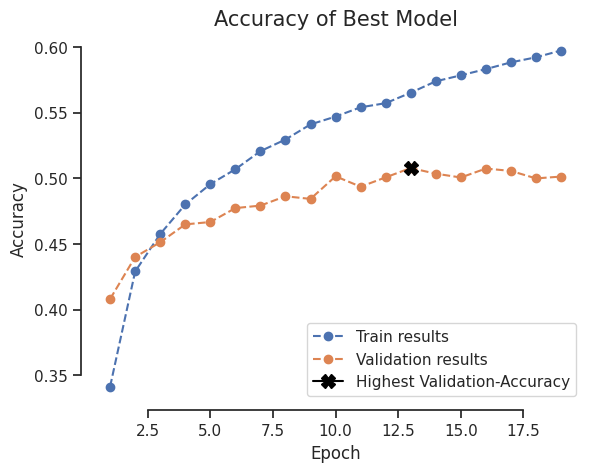

<Figure size 640x480 with 0 Axes>

In [236]:
# Your best model:
lr = 1e-3 
patience = 6
num_hidden_units = 50
num_hidden_layers = 1
act_fn = nn.ELU

best_model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=num_hidden_layers, num_hidden_units = num_hidden_units, act_fn = act_fn).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=lr)

stopper = EarlyStopper(patience=patience)
    
# Train the model
train_losses, val_losses, train_accs, val_accs, conf_matrix = run_training(best_model, optimizer, 
                                                                loss_function, device, 
                                                                num_epochs, trainloader, valloader, early_stopper=stopper, verbose = False)
    
max_acc_val = max(val_accs)
max_acc_val_epoch = val_accs.index(max_acc_val)+1
fig = plt.figure()
plot(f'Accuracy of Best Model','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_epoch,max_acc_val))
fig = plt.figure()
print(f'The highest accuracy achieved in this model is {max_acc_val}.')
print("")

Yes, it does. Since we optimized hyperparameters that are more suitable for the dataset. The value is higher than all other models => Best model (val acc > 50%)


#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

No, there is random variation in performance. I can confirm this since I ran this notebook multiple times. No, the models are not really comparable. We can also not definetely say that one alternative is strictly better than the other.

Would be only comparable if I would set the same seed at the beginning of each training and initialize dataloader etc.

Maybe save weights and use them as input for another model?

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO:
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too!

In [259]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    model.eval()
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)

    with torch.no_grad():
        for  x, y in test_loader:
            # Make predictions on the test set
            y_pred = model(x.to(device))
            
            
            #print(y)
            #print(y_pred.shape)
            # batch size = 1024 => shape of y_pred is (1024, 10); shape of y is (1024, 1)
            # For calculating accuracy, save the number of correctly classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim = 1)) # real value equals prediction? argmax selects the class with the highest predicted value as "winner" class (the one we would choose as prediction)
            epoch_total += len(y)

            # Fill the confusion matrix
            for (y_true, y_pred) in zip(y, y_pred.argmax(dim = 1)): 
                confusion_matrix[int(y_true), int(y_pred)] += 1

    # Calculate accuracy
    acc = accuracy(epoch_correct, epoch_total)

    return acc, confusion_matrix
    

In [262]:
# The accuracy and confusion matrix
print("The accuracy of my best model on the test data is:")
accuracy_test, confusion_matrix_test = test(testloader, best_model, device)
print(accuracy_test)

The accuracy of my best model on the test data is:
0.504


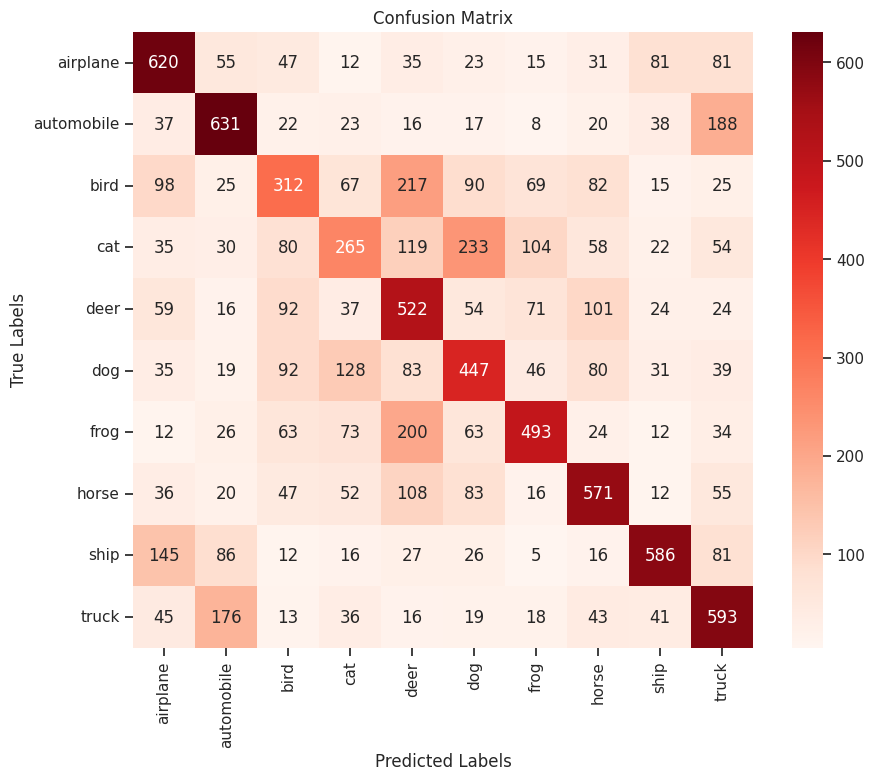

In [263]:
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def calc_confusion_values_absolute(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""
    
    # Set the model to evaluation mode
    model.eval()  

    y_true = [] 
    y_pred = [] 

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the batches in the dataloader
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: compute the predicted outputs of the model
            outputs = model(inputs)

            # Obtain the predicted class indices by finding the maximum value along the output's dimension 1
            _, predicted = torch.max(outputs, dim=1)

            # Extend the lists of true labels and predicted labels with the current batch's values
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predicted.cpu().numpy().tolist())

    # Compute the confusion matrix using scikit-learn's confusion_matrix function
    confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)
    

    return confusion 



# Calculate the confusion matrix
confusion_matrix = calc_confusion_values_absolute(testloader, best_model, device)

# Define class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

remember that the test set contains 10k images; about the half are classified correctly; equally balanced classes?

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

The diagonal elements of the confusion matrix represent the number of correctly predicted instances for each class.

- especially on cats and birds. They are especially confused with dogs and deers. Frogs are sometimes confused with deers and automobiles with trucks.

- Yes, almost. 0.504 (test acc) vs. 0.5078 (validation acc)

- not so much difference here. Validation set is a bit better. I tune the hyperparameters based on the validation set. My model thus fits better to the validation set.

- Since the test set only should give an outlook on the future performance of the model. If I would try out hyperparameters on the test set, I would kind of fit my model to that sence and thereby negate its explanatory power. There is also a risk of leaking information from the test set into the model selection process. Consequently, my model may perform well on the test set simply because it has been tuned to that specific data, rather than because it generalizes well to unseen data. => This is actually the scope of the test data. We want to test the model on completely unseen data/data the model never came in touch with. We want to test generalization of the model.



## How about the optimizer? _(optional)_

_This task is optional, you do not need to solve it_

Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.

#### TODO *(optional)*:

- Run training of the same model used above with
    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)
- Compare your training results of all the different optimizer settings from above.
- What is your observation while using different optimizers? What is the respective impact on the model performance?

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*:
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).

In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################